In [67]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import random
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import lenstronomy_sim, survey_sim, gs

In [68]:
# output_dir = '/data/scratch/btwedig/mejiro/pipeline/debug/max_recursion_limit'
output_dir = '/data/bwedig/mejiro/pipeline_dev/debug/max_recursion_limit'
files = glob(f'{output_dir}/*.pkl')
arrays = [util.unpickle(f) for f in files]

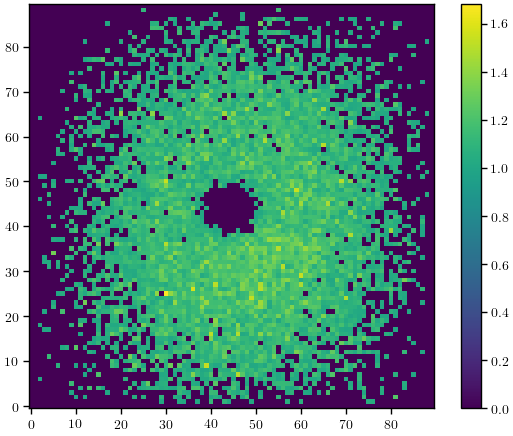

In [69]:
sample = random.choice(arrays)

plt.imshow(sample)
plt.colorbar()
plt.show()

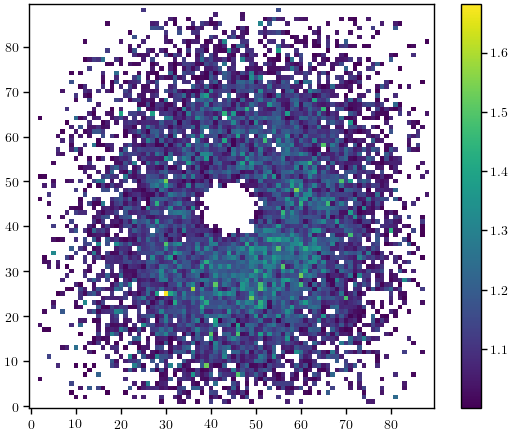

In [70]:
masked_array = np.ma.masked_where(sample == 0, sample)
original = deepcopy(masked_array)

plt.imshow(masked_array)
plt.colorbar()
plt.show()

In [71]:
pprint(masked_array.mask)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])


In [72]:
pprint(masked_array.data)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)


In [73]:
x_shape, y_shape = masked_array.shape

masked_array.data[0, 10] = 1
masked_array.data[0, 0] = 1
masked_array.data[x_shape - 1, y_shape - 1] = 1

coords = []
for x in range(0, x_shape):
    for y in range(0, y_shape):
        if masked_array.data[x, y] != 0:
            if x == 0 and y == 0:  # bottom left corner
                if masked_array.data[x + 1, y] == 0 and masked_array.data[x, y + 1] == 0:
                    masked_array.mask[x, y] = True
            elif x == 0 and y == y_shape - 1:  # top left corner
                if masked_array.data[x + 1, y] == 0 and masked_array.data[x, y - 1] == 0:
                    masked_array.mask[x, y] = True
            elif x == x_shape and y == 0:  # bottom right corner
                if masked_array.data[x - 1, y] == 0 and masked_array.data[x, y + 1] == 0:
                    masked_array.mask[x, y] = True
            elif x == x_shape - 1 and y == y_shape - 1:  # top right corner
                if masked_array.data[x - 1, y] == 0 and masked_array.data[x, y - 1] == 0:
                    masked_array.mask[x, y] = True
            elif x == 0:  # left edge (not corners)
                if masked_array.data[x + 1, y] == 0 and masked_array.data[x, y + 1] == 0 and masked_array.data[
                    x, y - 1] == 0:
                    masked_array.mask[x, y] = True
            elif x == x_shape - 1:  # right edge (not corners)
                if masked_array.data[x - 1, y] == 0 and masked_array.data[x, y - 1] == 0 and masked_array.data[
                    x, y + 1] == 0:
                    masked_array.mask[x, y] = True
            elif y == 0:  # bottom edge (not corners)
                if masked_array.data[x - 1, y] == 0 and masked_array.data[x + 1, y] == 0 and masked_array.data[
                    x, y + 1] == 0:
                    masked_array.mask[x, y] = True
            elif y == y_shape - 1:  # top edge (not corners)
                if masked_array.data[x - 1, y] == 0 and masked_array.data[x + 1, y] == 0 and masked_array.data[
                    x, y - 1] == 0:
                    masked_array.mask[x, y] = True
            elif masked_array.data[x - 1, y] == 0 and masked_array.data[x + 1, y] == 0 and masked_array.data[
                x, y - 1] == 0 and masked_array.data[x, y + 1] == 0:
                masked_array.mask[x, y] = True

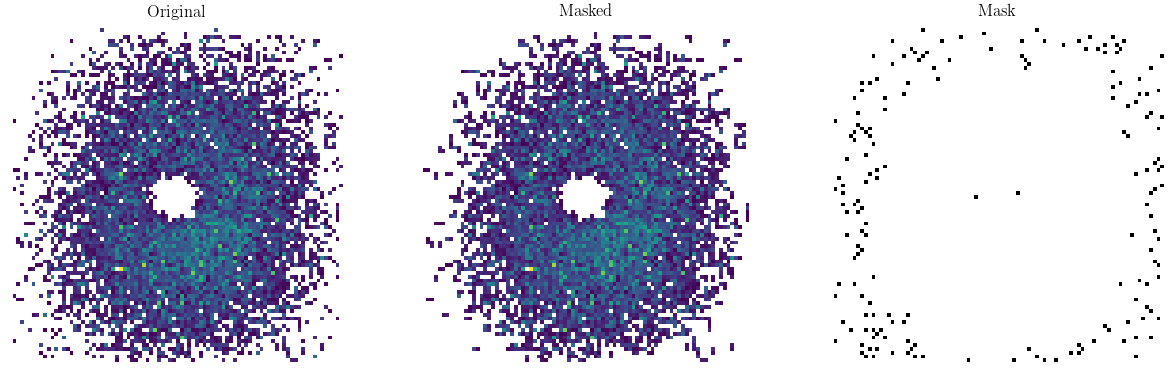

In [75]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(original)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(masked_array)
ax[1].set_title('Masked')
ax[1].axis('off')
ax[2].imshow(original.mask != masked_array.mask, cmap='binary')
ax[2].set_title('Mask')
ax[2].axis('off')
plt.show()